In [2]:
import os
import sys
import pandas as pd
import math
import matplotlib.pyplot as plt
import sweetviz as sv
import numpy as np
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import roc_auc_score, roc_curve, r2_score
from scipy.stats import spearmanr, pearsonr

In [3]:
os.chdir('./scripts')

import load_config

In [4]:
config = load_config.load_config_const()
plt.style.use('seaborn')

# Obtención de serie temporal de traspasos diarios de turismos

El objetivo de este notebook es crear una serie temporal en la que se calcule el número de traspasos de turismos. Primero realizaremos la carga del dataframe con una función que ya nos dará muchos de los campos formateados del notebook anterior

In [5]:
df_dgt = load_config.obtain_dgt_dataset(config, 0.3)
df_dgt.sample(10)

Processing export_anual_trf_2015.csv.tar.gz
### Lines -> 676456
### Create main datagrame
### Total lines -> 676456
Processing export_anual_trf_2016.csv.tar.gz
### Lines -> 735819
### Merge with main datagrame
### Total lines -> 1412275
Processing export_anual_trf_2017.csv.tar.gz
### Lines -> 821522
### Merge with main datagrame
### Total lines -> 2233797
Processing export_anual_trf_2018.csv.tar.gz
### Lines -> 878704
### Merge with main datagrame
### Total lines -> 3112501
Processing export_anual_trf_2019.csv.tar.gz
### Lines -> 889705
### Merge with main datagrame
### Total lines -> 4002206
Processing export_anual_trf_2020.csv.tar.gz
### Lines -> 752514
### Merge with main datagrame
### Total lines -> 4754720
Processing export_anual_trf_2021.csv.tar.gz
### Lines -> 839338
### Merge with main datagrame
### Total lines -> 5594058


,FEC_MATRICULA,COD_CLASE_MAT,FEC_TRAMITACION,MARCA_ITV,MODELO_ITV,COD_PROCEDENCIA_ITV,COD_PROPULSION_ITV,CILINDRADA_ITV,POTENCIA_ITV,NUM_PLAZAS,...,NIVEL_EMISIONES_EURO_ITV,CONSUMO_WH/KM_ITV,CATEGORÍA_VEHÍCULO_ELÉCTRICO,AUTONOMÍA_VEHÍCULO_ELÉCTRICO,year_Q,Q_query,ID_MUNICIPIO,month_year_Q,day_of_week,is_weekend
1843559,2001-01-23,0.0,2021-09-02,VOLKSWAGEN,GOLF 1.6 2P 5V,0.0,0,1598,11.63,5,...,EURO 3,0.0,NaN,NaN,2021,3,38,9,Thursday,False
349654,2010-05-28,0.0,2021-02-18,TOYOTA,PRIUS ECO,1.0,0.0,1798,12.49,5,...,EURO 5,0.0,HEV,0.0,2021,1,28,2,Thursday,False
1054884,2005-09-06,0.0,2015-06-29,MERCEDES-BENZ,SLK 200,3.0,0.0,1998,13.31,2,...,EURO 2,0.0,NaN,NaN,2015,2,15,6,Monday,False
2432288,2004-09-08,0.0,2017-11-27,VOLKSWAGEN,GOLF 1.9,3.0,1,1896,12.89,5,...,EURO 3,0.0,NaN,NaN,2017,4,28,11,Monday,False
2719732,2002-04-23,0.0,2021-12-22,BMW,SERIE 320TD,3.0,1,1995,0.13,5,...,EURO 3,0.0,NaN,NaN,2021,4,21,12,Wednesday,False
446850,2014-05-14,0.0,2020-02-24,MERCEDES-BENZ,C 220 BLUETEC,3.0,1,2143,13.88,5,...,EURO 6-T,0.0,NaN,NaN,2020,1,03,2,Monday,False
723360,2020-05-19,0.0,2020-05-21,AUDI,AUDI A6,3.0,1,2698,18.74,5,...,EURO 4,0.0,NaN,0.0,2020,2,04,5,Thursday,False
2211696,2004-04-19,0.0,2019-10-08,PEUGEOT,206 1.4,3.0,1,1398,10.75,5,...,EURO 3,0.0,NaN,NaN,2019,4,10,10,Tuesday,False
677866,2014-05-19,0.0,2017-04-04,CITROEN,C3 HDI 70 COLLECTION,3.0,1.0,1398,10.75,5,...,EURO 5,0.0,NaN,NaN,2017,2,14,4,Tuesday,False
2084032,2002-06-13,0.0,2019-09-24,MERCEDES-BENZ,E 270,3.0,1,2685,17.37,5,...,EURO 3,0.0,NaN,NaN,2019,3,41,9,Tuesday,False


El siguiente paso es agrupar todas las transacciones por las fechas en las que se producen. Esto nos dará la cuantía diaria de trasacciones

In [6]:
temporal_df_dgt = df_dgt.groupby(["FEC_TRAMITE"]).size().reset_index(name='count')

In [7]:
temporal_df_dgt.sort_values('FEC_TRAMITE', ascending=True)

,FEC_TRAMITE,count
0,2015-01-01,2
1,2015-01-02,772
2,2015-01-03,2
3,2015-01-04,28
4,2015-01-05,1153
...,...,...
2357,2021-12-27,5555
2358,2021-12-28,4799
2359,2021-12-29,5565
2360,2021-12-30,5529


Crearemos un nuevo campo para la fecha, ya que el objetivo es usarla como indice para ordenar el dataframa

In [8]:
temporal_df_dgt['date'] = temporal_df_dgt['FEC_TRAMITE']
temporal_df_dgt

,FEC_TRAMITE,count,date
0,2015-01-01,2,2015-01-01
1,2015-01-02,772,2015-01-02
2,2015-01-03,2,2015-01-03
3,2015-01-04,28,2015-01-04
4,2015-01-05,1153,2015-01-05
...,...,...,...
2357,2021-12-27,5555,2021-12-27
2358,2021-12-28,4799,2021-12-28
2359,2021-12-29,5565,2021-12-29
2360,2021-12-30,5529,2021-12-30


In [9]:
temporal_df_dgt = temporal_df_dgt.set_index('FEC_TRAMITE')

In [10]:
temporal_df_dgt

,count,date
FEC_TRAMITE,,
2015-01-01,2,2015-01-01
2015-01-02,772,2015-01-02
2015-01-03,2,2015-01-03
2015-01-04,28,2015-01-04
2015-01-05,1153,2015-01-05
...,...,...
2021-12-27,5555,2021-12-27
2021-12-28,4799,2021-12-28
2021-12-29,5565,2021-12-29


Mediante la siguiente linea de código, obtendremos las fechas en las cuales no tenemos registros de trasacciones (lo que interrumpiría la serie temporal)

In [11]:
idx = pd.date_range(start = temporal_df_dgt["date"].min(), end = temporal_df_dgt["date"].max() , freq="d").difference(temporal_df_dgt["date"])

In [12]:
idx

DatetimeIndex(['2015-01-24', '2015-02-14', '2015-02-28', '2015-03-28',
               '2015-05-23', '2015-05-30', '2015-06-28', '2015-09-13',
               '2015-09-27', '2015-11-08',
               ...
               '2020-03-29', '2020-04-05', '2020-04-11', '2020-04-18',
               '2020-04-19', '2020-04-26', '2020-05-03', '2020-05-10',
               '2020-07-12', '2021-06-19'],
              dtype='datetime64[ns]', length=195, freq=None)

In [13]:
temporal_df_dgt_no_data = pd.DataFrame({'FEC_TRAMITE': idx})
temporal_df_dgt_no_data

,FEC_TRAMITE
0,2015-01-24
1,2015-02-14
2,2015-02-28
3,2015-03-28
4,2015-05-23
...,...
190,2020-04-26
191,2020-05-03
192,2020-05-10
193,2020-07-12


A partir de estas fechas obtendremos un nuevo dataframe, el cual iremos rellenando con las columnas de nuestro dataframe original

In [14]:
temporal_df_dgt_no_data['date'] = temporal_df_dgt_no_data['FEC_TRAMITE']
temporal_df_dgt_no_data

,FEC_TRAMITE,date
0,2015-01-24,2015-01-24
1,2015-02-14,2015-02-14
2,2015-02-28,2015-02-28
3,2015-03-28,2015-03-28
4,2015-05-23,2015-05-23
...,...,...
190,2020-04-26,2020-04-26
191,2020-05-03,2020-05-03
192,2020-05-10,2020-05-10
193,2020-07-12,2020-07-12


In [15]:
temporal_df_dgt_no_data['count'] = 0
temporal_df_dgt_no_data

,FEC_TRAMITE,date,count
0,2015-01-24,2015-01-24,0
1,2015-02-14,2015-02-14,0
2,2015-02-28,2015-02-28,0
3,2015-03-28,2015-03-28,0
4,2015-05-23,2015-05-23,0
...,...,...,...
190,2020-04-26,2020-04-26,0
191,2020-05-03,2020-05-03,0
192,2020-05-10,2020-05-10,0
193,2020-07-12,2020-07-12,0


Ya que en principio no tenemos datos de las ventas, indicamos que han sido 0, luego les daremos un valor

In [16]:
temporal_df_dgt_no_data = temporal_df_dgt_no_data.set_index('FEC_TRAMITE')
temporal_df_dgt_no_data

,date,count
FEC_TRAMITE,,
2015-01-24,2015-01-24,0
2015-02-14,2015-02-14,0
2015-02-28,2015-02-28,0
2015-03-28,2015-03-28,0
2015-05-23,2015-05-23,0
...,...,...
2020-04-26,2020-04-26,0
2020-05-03,2020-05-03,0
2020-05-10,2020-05-10,0


Luego te tener nuestro nuevo dataframe con las fechas sin datos, lo concatenaremos a nuestro dataset original

In [17]:
frames = [temporal_df_dgt, temporal_df_dgt_no_data]

result_dgt = pd.concat(frames)

In [18]:
result_dgt.sort_values('date', ascending=False)

,count,date
FEC_TRAMITE,,
2021-12-31,7,2021-12-31
2021-12-30,5529,2021-12-30
2021-12-29,5565,2021-12-29
2021-12-28,4799,2021-12-28
2021-12-27,5555,2021-12-27
...,...,...
2015-01-05,1153,2015-01-05
2015-01-04,28,2015-01-04
2015-01-03,2,2015-01-03


Indicaremos que días son fin de semana frente a los días ordinarios

In [20]:
def is_weekend(day_week):
    if (day_week == 'Saturday' or day_week == 'Sunday'):
        return 1.0
    else:
        return 0.0
    return False

In [21]:
result_dgt['is_weekend'] = result_dgt['date'].dt.day_name().apply(lambda x: is_weekend(x))

In [22]:
result_dgt.sort_values('date', ascending=True)

,count,date,is_weekend
FEC_TRAMITE,,,
2015-01-01,2,2015-01-01,0.0
2015-01-02,772,2015-01-02,0.0
2015-01-03,2,2015-01-03,1.0
2015-01-04,28,2015-01-04,1.0
2015-01-05,1153,2015-01-05,0.0
...,...,...,...
2021-12-27,5555,2021-12-27,0.0
2021-12-28,4799,2021-12-28,0.0
2021-12-29,5565,2021-12-29,0.0


Añadiremos nuevos campos para indicar los ciclos de semanas, meses y años. Tal como vimos en el notebook anterior, es importante recalcar estos periodos, ya que condicionan los traspasos y su frecuencia 

In [23]:
x = np.arange(len(result_dgt))

result_dgt["s_period_week"] = np.sin(2*np.pi*x/7)
result_dgt["s_period_month"] = np.sin(2*np.pi*x/30.5)
result_dgt["s_period_year"] = np.sin(2*np.pi*x/365 )

result_dgt["c_period_week"] = np.cos(2*np.pi*x/7)
result_dgt["c_period_month"] = np.cos(2*np.pi*x/30.5)
result_dgt["c_period_year"] = np.cos(2*np.pi*x/365 )

In [24]:
result_dgt.sort_values('date', ascending=True)

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,
2015-01-01,2,2015-01-01,0.0,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000
2015-01-02,772,2015-01-02,0.0,7.818315e-01,0.204552,0.017213,0.623490,0.978856,0.999852
2015-01-03,2,2015-01-03,1.0,9.749279e-01,0.400454,0.034422,-0.222521,0.916317,0.999407
2015-01-04,28,2015-01-04,1.0,4.338837e-01,0.579421,0.051620,-0.900969,0.815028,0.998667
2015-01-05,1153,2015-01-05,0.0,-4.338837e-01,0.733885,0.068802,-0.900969,0.679273,0.997630
...,...,...,...,...,...,...,...,...,...
2021-12-27,5555,2021-12-27,0.0,-9.749279e-01,0.983798,0.263665,-0.222521,-0.179281,-0.964614
2021-12-28,4799,2021-12-28,0.0,-7.818315e-01,0.926324,0.247022,0.623490,-0.376728,-0.969010
2021-12-29,5565,2021-12-29,0.0,-2.175443e-13,0.829677,0.230306,1.000000,-0.558244,-0.973118


Llega el momento de rellenar los valores de los que no disponíamos información. Para ello diferenciaremos entre los días que son fin de semana de los que no, y con ello se les agregará dos medias diferentes

In [25]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0)]['count']

FEC_TRAMITE
2015-01-24    0
2015-02-14    0
2015-02-28    0
2015-03-28    0
2015-05-23    0
             ..
2020-04-26    0
2020-05-03    0
2020-05-10    0
2020-07-12    0
2021-06-19    0
Name: count, Length: 185, dtype: int64

In [26]:
result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 1.0)]['count'].mean()

6.581651376146789

In [27]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0)]['count']

FEC_TRAMITE
2017-10-12    0
2018-01-01    0
2018-03-30    0
2018-05-01    0
2018-10-12    0
2018-12-06    0
2019-01-01    0
2019-08-15    0
2019-11-01    0
2020-01-01    0
Name: count, dtype: int64

In [28]:
result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 0.0)]['count'].mean()

3076.7589433131534

In [29]:
result_dgt.loc[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0),'count'] = result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 1.0)]['count'].mean()

In [30]:
result_dgt.loc[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0),'count'] = result_dgt[(result_dgt['count'] != 0) & (result_dgt['is_weekend'] == 0.0)]['count'].mean()

In [31]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 1.0)]

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,


In [32]:
result_dgt[(result_dgt['count'] == 0) & (result_dgt['is_weekend'] == 0.0)]

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,


In [33]:
result_dgt[result_dgt['date'] == '2015-02-21']

,count,date,is_weekend,s_period_week,s_period_month,s_period_year,c_period_week,c_period_month,c_period_year
FEC_TRAMITE,,,,,,,,,
2015-02-21,2.0,2015-02-21,1.0,-1.714506e-15,-0.620609,0.746972,1.0,-0.78412,0.664855


Hecho esto, ya tenemos nuestra linea de tiempo completa

<AxesSubplot:xlabel='date', ylabel='count'>

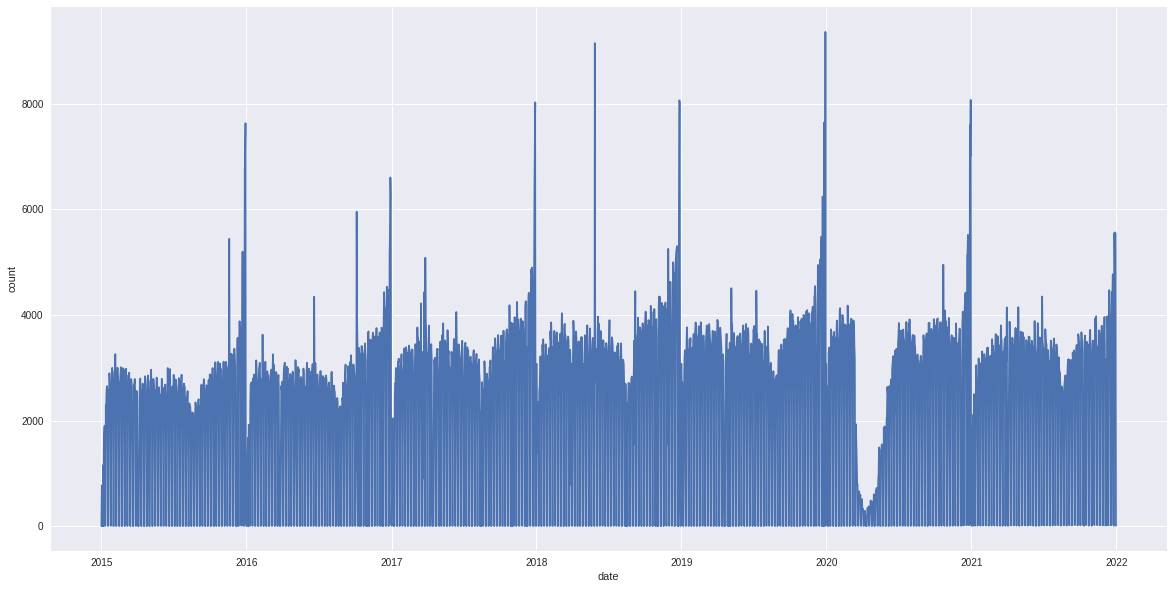

In [34]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt, x='date', y='count', ax=ax)

Para comparar nuestras predicciones con los valores reales, vamos a tomar un periodo de tiempo concreto, los últimos 4 meses del año 2021 (mostraremos los 5 últimos)

<AxesSubplot:xlabel='date', ylabel='count'>

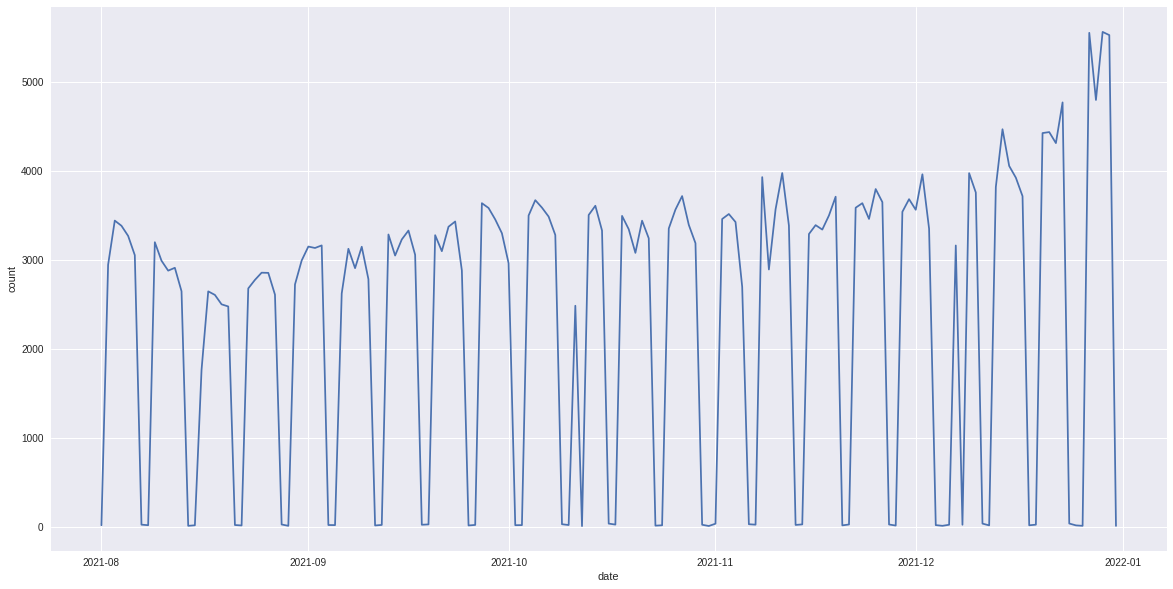

In [35]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt[result_dgt['date'] >= '2021-08-01' ], x='date', y='count', ax=ax)

Definiremos los campos predictores como el campo a predecir, pero añadiremos la fecha en ambos para realizar el corte de los últimos 4 meses

In [38]:
X = result_dgt[[
    'date', 'is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year'
]]

y = result_dgt[['date','count']]

In [39]:
X

,date,is_weekend,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_year
FEC_TRAMITE,,,,,,,,
2015-01-01,2015-01-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000
2015-01-02,2015-01-02,0.0,7.818315e-01,7.818315e-01,1.721336e-02,0.623490,0.623490,0.999852
2015-01-03,2015-01-03,1.0,9.749279e-01,9.749279e-01,3.442161e-02,-0.222521,-0.222521,0.999407
2015-01-04,2015-01-04,1.0,4.338837e-01,4.338837e-01,5.161967e-02,-0.900969,-0.900969,0.998667
2015-01-05,2015-01-05,0.0,-4.338837e-01,-4.338837e-01,6.880243e-02,-0.900969,-0.900969,0.997630
...,...,...,...,...,...,...,...,...
2020-04-26,2020-04-26,1.0,-4.338837e-01,-4.338837e-01,-5.161967e-02,-0.900969,-0.900969,0.998667
2020-05-03,2020-05-03,1.0,-9.749279e-01,-9.749279e-01,-3.442161e-02,-0.222521,-0.222521,0.999407
2020-05-10,2020-05-10,1.0,-7.818315e-01,-7.818315e-01,-1.721336e-02,0.623490,0.623490,0.999852


Obtenemos los datos de entrenamiento y los de test (los últimos 4 meses)

In [41]:
train_X = X[X['date'] < '2021-09-01']
test_X = X[X['date'] >= '2021-09-01']

train_y = y[y['date'] < '2021-09-01']
test_y = y[y['date'] >= '2021-09-01']

Y, luego de ello, eliminamos la columna de fecha

In [42]:
X = X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]
y = y['count']

train_X = train_X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]
test_X = test_X[['is_weekend', 's_period_week', 's_period_week', 's_period_year', 'c_period_week', 'c_period_week', 'c_period_year']]

train_y = train_y['count']
test_y = test_y['count']

Realizaremos las predicciones usando un RandomForestRegressor. Primero realizaremos una predicción con unos metadatos al azar para ver como se comporta nuestro modelo

In [44]:
rf = RandomForestRegressor(n_estimators=600, min_samples_split=5, oob_score=True, max_depth=5)
rf.fit(train_X, train_y)

RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=600,
                      oob_score=True)

In [45]:
rf.oob_score_

0.7179891966831201

In [46]:
rf.predict(train_X)

array([2794.17344465, 3057.73074312,    5.09250983, ...,    4.70404999,
          4.53409751,    4.80011405])

In [47]:
y_hat = rf.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.718
Test data R-2 score: 0.731


In [48]:
from sklearn.model_selection import cross_val_score

cross_val_score(X=train_X,y=train_y, estimator=rf )

array([0.56363776, 0.72507404, 0.55925249, 0.49177044, 0.8536846 ])

LLega el turno de usar un GridSearchCV para comprobar que configuración de nuestro modelo tiene mejores predicciones

In [49]:
grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_leaf_nodes': [5,10,25,50,100]
}


grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid=grid,
    scoring="neg_mean_squared_error",
    verbose=2
)

In [50]:
grid_search.fit(train_X,train_y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_sp

[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=300; total time=   0.6s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=5, min_samples_split=8, n_estimators=400; total time=   0.8s
[CV] END max_depth=5

[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=6, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=10, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END 

[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=300; total time=   0.8s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=25, min_samples_split=8, n_estimators=400; total time=   1.0s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.3s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.2s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=4, n_estimators=500; total time=   1.3s
[CV] END m

[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=5, max_leaf_nodes=50, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=2, n_estimators=200; total time=   0.5s


[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=5, max_leaf_nodes=100, min_samples_split=8, n_estimators=300; total time=   0.7s


[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=300; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=400; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=4, n_estimators=500; total time=   1.0s
[CV] END m

[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=5, min_samples_split=10, n_estimators=500; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=2, n_estimators=200; total time=   0.4s


[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.4s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=200; total time=   0.5s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=10, min_samples_split=8, n_estimators=300; total time=   0.7s


[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=300; total time=   0.8s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=4, n_estimators=400; total time=   1.0s


[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=400; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.3s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=25, min_samples_split=10, n_estimators=500; total time=   1.5s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=2, n_estimators=100; total time=

[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=6, n_estimators=500; total time=   1.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_leaf_nodes=50, min_samples_split=8, n_estimators=200; total time=   0.6s


[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=4, n_estimators=400; total tim

[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=500; total time=   1.8s
[CV] END max_depth=10, max_leaf_nodes=100, min_samples_split=10, n_estimators=500;

[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=6, n_estimators=500; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=5, min_samples_split=8, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=200; total time=   0.5s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=4, n_estimators=300; total time=   0.7s


[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=10, min_samples_split=10, n_estimators=400; total tim

[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.1s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.1s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=400; total time=   1.2s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.4s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=6, n_estimators=500; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=8, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=25, min_samples_split=8, n_estimators=100; total time=   0.3s


[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=2, n_estimators=500; total time=   1.8s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=4, n_estimators=200; total time=   0.7s


[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END max_depth=15, max_leaf_nodes=50, min_samples_split=10, n_estimators=400; total tim

[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=300; total time=   1.1s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=300; total time=   1.3s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.6s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.5s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=400; total time=   1.8s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total time=   2.0s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total time=   2.0s
[CV] END max_depth=15, max_leaf_nodes=100, min_samples_split=6, n_estimators=500; total tim

[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=2, n_estimators=500; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=4, n_estimators=100; total time=   0.2s
[CV] END m

[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=200; total time=   0.5s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=5, min_samples_split=10, n_estimators=300; total time=   0.6s


[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=300; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=10, min_samples_split=6, n_estimators=400; total time=   0.9s


[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=400; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=2, n_estimators=500; total time=   1.4s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=4, n_estimators=100; total time=   0.3s


[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=8, n_estimators=500; total time=   1.5s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=25, min_samples_split=10, n_estimators=200; total time

[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.6s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=200; total time=   0.7s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   0.9s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=300; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=50, min_samples_split=6, n_estimators=400; total time=   1.5s


[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=300; total time=   1.0s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=300; total time=   1.1s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=400; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total time=   2.0s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total time=   1.9s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=2, n_estimators=500; total tim

[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.8s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=8, n_estimators=500; total time=   1.9s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, max_leaf_nodes=100, min_samples_split=10, n_estimators=100; tota

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_leaf_nodes': [5, 10, 25, 50, 100],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [51]:
grid_search.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 5,
 'min_samples_split': 2,
 'n_estimators': 200}

In [52]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.187791,0.002555,0.009493,0.000624,5,5,2,100,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-753498.361164,-553822.977829,-1.110084e+06,-1.358153e+06,-418898.575497,-838891.447443,348748.662955,10
1,0.361930,0.002396,0.016414,0.000106,5,5,2,200,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-748134.382023,-556342.884257,-1.105419e+06,-1.356961e+06,-415771.468267,-836525.884030,348283.406384,1
2,0.555131,0.013340,0.023724,0.000155,5,5,2,300,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-749754.729545,-556158.237235,-1.119019e+06,-1.359060e+06,-418671.794835,-840532.795289,350286.049726,64
3,0.750374,0.009849,0.031277,0.000363,5,5,2,400,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-749269.843393,-560848.449434,-1.112362e+06,-1.361898e+06,-418235.626240,-840522.800235,349456.703785,62
4,0.999363,0.018009,0.040430,0.000396,5,5,2,500,"{'max_depth': 5, 'max_leaf_nodes': 5, 'min_sam...",-748829.355391,-557632.756038,-1.114950e+06,-1.361714e+06,-416534.677524,-839932.289974,350756.234254,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.362233,0.022779,0.011749,0.000507,20,100,10,100,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-858320.510008,-654646.809457,-1.215907e+06,-1.455335e+06,-480901.832078,-933022.187166,357860.437481,447
496,0.738516,0.033842,0.021398,0.000842,20,100,10,200,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-855419.578369,-648991.541401,-1.217753e+06,-1.463608e+06,-487118.479079,-934578.103988,360029.620728,449
497,1.135644,0.085419,0.032246,0.001081,20,100,10,300,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-861120.881170,-649164.613040,-1.226457e+06,-1.460659e+06,-486868.772702,-936854.080242,360341.285714,456
498,1.606378,0.064236,0.045563,0.002611,20,100,10,400,"{'max_depth': 20, 'max_leaf_nodes': 100, 'min_...",-857129.216012,-648396.470301,-1.229488e+06,-1.461458e+06,-487425.150643,-936779.513538,361218.675355,455


Con la configuración óptima, volvemos a crear un nuevo modelo para tomar mediciones

In [85]:
rf_final = RandomForestRegressor(n_estimators=200, min_samples_split=2, oob_score=True, max_depth=5, max_leaf_nodes=5)
rf_final.fit(train_X, train_y)

RandomForestRegressor(max_depth=5, max_leaf_nodes=5, n_estimators=200,
                      oob_score=True)

In [86]:
rf_final.oob_score_

0.7229408614047511

Y hacemos una comparativa de resultados con el primer modelo

In [88]:
y_hat = rf_final.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf_final.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.723
Test data R-2 score: 0.724


In [89]:
cross_val_score(X=train_X,y=train_y, estimator=rf_final )

array([0.57597549, 0.73269636, 0.56420438, 0.5093845 , 0.85735629])

In [90]:
y_hat = rf.predict(test_X)

test_score = r2_score(test_y, y_hat)


print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')

Out-of-bag R-2 score estimate: 0.718
Test data R-2 score: 0.731


In [91]:
cross_val_score(X=train_X,y=train_y, estimator=rf )

array([0.5637017 , 0.72609302, 0.56046609, 0.49247745, 0.85378745])

Si bien los resultados son mejores, esa mejoría es apenas perceptible en los resultados

Llega el momento de hacer una comparación entre nuestras predicciones y la realidad

In [93]:
df_graph_final = test_X.copy()

In [94]:
df_graph_final.sample(10)

,is_weekend,s_period_week,s_period_week,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_week,c_period_week,c_period_year
FEC_TRAMITE,,,,,,,,,,,
2021-11-26,0.0,9.749279e-01,9.749279e-01,9.749279e-01,9.749279e-01,0.717677,-0.222521,-0.222521,-0.222521,-0.222521,-0.696376
2021-12-16,0.0,7.818315e-01,7.818315e-01,7.818315e-01,7.818315e-01,0.440519,0.623490,0.623490,0.623490,0.623490,-0.897743
2021-09-08,0.0,-9.993861e-14,-9.993861e-14,-9.993861e-14,-9.993861e-14,0.831171,1.000000,1.000000,1.000000,1.000000,0.556017
2021-10-20,0.0,-1.932200e-15,-1.932200e-15,-1.932200e-15,-1.932200e-15,0.991114,1.000000,1.000000,1.000000,1.000000,-0.133015
2021-10-04,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,0.989932,-0.222521,-0.222521,-0.222521,-0.222521,0.141540
2021-12-11,1.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,0.516062,-0.900969,-0.900969,-0.900969,-0.900969,-0.856551
2021-12-12,1.0,-4.338837e-01,-4.338837e-01,-4.338837e-01,-4.338837e-01,0.501242,-0.900969,-0.900969,-0.900969,-0.900969,-0.865307
2021-10-16,1.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,0.997917,-0.900969,-0.900969,-0.900969,-0.900969,-0.064508
2021-11-28,1.0,-4.338837e-01,-4.338837e-01,-4.338837e-01,-4.338837e-01,0.693281,-0.900969,-0.900969,-0.900969,-0.900969,-0.720667


In [95]:
df_graph_final['date'] = df_graph_final.index

In [96]:
df_graph_final.sample(10)

,is_weekend,s_period_week,s_period_week,s_period_week,s_period_week,s_period_year,c_period_week,c_period_week,c_period_week,c_period_week,c_period_year,date
FEC_TRAMITE,,,,,,,,,,,,
2021-11-20,1.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,0.785650,-0.900969,-0.900969,-0.900969,-0.900969,-0.618671,2021-11-20
2021-12-20,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,0.377708,-0.222521,-0.222521,-0.222521,-0.222521,-0.925925,2021-12-20
2021-11-05,0.0,9.749279e-01,9.749279e-01,9.749279e-01,9.749279e-01,0.917584,-0.222521,-0.222521,-0.222521,-0.222521,-0.397543,2021-11-05
2021-12-08,0.0,7.451300e-14,7.451300e-14,7.451300e-14,7.451300e-14,0.559589,1.000000,1.000000,1.000000,1.000000,-0.828770,2021-12-08
2021-11-30,0.0,-7.818315e-01,-7.818315e-01,-7.818315e-01,-7.818315e-01,0.668064,0.623490,0.623490,0.623490,0.623490,-0.744104,2021-11-30
2021-11-08,0.0,-9.749279e-01,-9.749279e-01,-9.749279e-01,-9.749279e-01,0.895839,-0.222521,-0.222521,-0.222521,-0.222521,-0.444378,2021-11-08
2021-12-05,1.0,-4.338837e-01,-4.338837e-01,-4.338837e-01,-4.338837e-01,0.601624,-0.900969,-0.900969,-0.900969,-0.900969,-0.798779,2021-12-05
2021-11-13,1.0,4.338837e-01,4.338837e-01,4.338837e-01,4.338837e-01,0.854322,-0.900969,-0.900969,-0.900969,-0.900969,-0.519744,2021-11-13
2021-11-18,0.0,7.818315e-01,7.818315e-01,7.818315e-01,7.818315e-01,0.806480,0.623490,0.623490,0.623490,0.623490,-0.591261,2021-11-18


In [98]:
df_graph_final['count'] = rf_final.predict(test_X)

<AxesSubplot:xlabel='date', ylabel='count'>

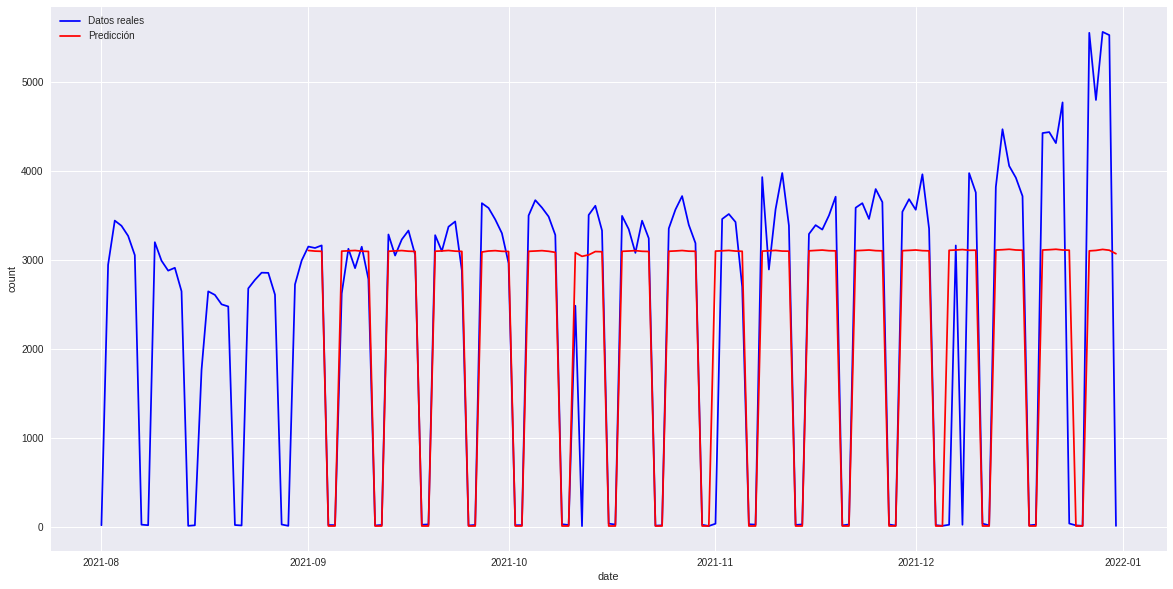

In [99]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(data=result_dgt[result_dgt['date'] >= '2021-08-01' ], x='date', y='count', ax=ax, color='blue', label='Datos reales')
sns.lineplot(data=df_graph_final, x='date', y='count', ax=ax, color='red', label='Predicción')

## Conclusiones

- El modelo consigue predecir el descenso de transacciones los finesl de semana
- Dependiendo de las iteracciones, consigue o no el aumento al final de año (esto puede ser debido al fracionamiento de los datos, ya que a cada generación se trae un porcentaje bajo de los mismo, pero a un volumen mayor el kernel se satura)